Credit risk prediction machine learning models

In [49]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer  # Needed to enable the IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [54]:
df_credit = pd.read_csv("data/german_credit_data.csv", index_col=0)

In [36]:
# Display the first few rows of the dataset
print(df_credit.head())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  


The dataset consists of 1000 observations and 10 features

In [37]:
print(df_credit.shape)

(1000, 10)


Most of the participants have good credit risk (70%), while the remainder have bad credit risk. This indicates a class imbalance in the dataset, with a significantly higher proportion of participants having good credit risk compared to those with bad credit risk. This imbalance can impact the performance and fairness of predictive models, necessitating the use of specialized techniques to address it.

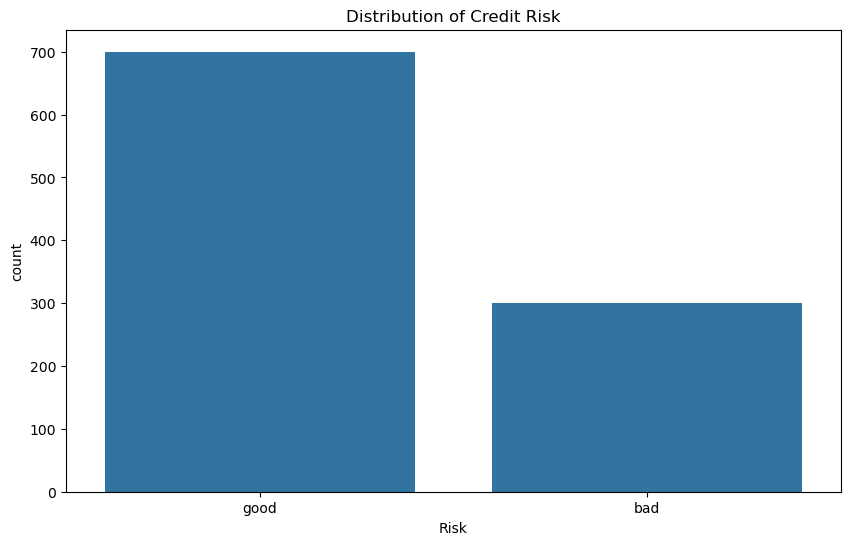

In [38]:
# EDA
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk', data=df_credit)
plt.title('Distribution of Credit Risk')
plt.show()

The features Age, Sex, Job, Housing, Credit amount, Duration, Purpose, and Risk have no missing values, indicating that data for these attributes is fully available for all participants in the dataset. In contrast, the Saving accounts feature has 183 missing values, meaning that information on saving accounts is unavailable for a portion of participants. The Checking account feature has 394 missing values, representing a significant amount of missing data, with over one-third of the data potentially missing depending on the total dataset size. These missing values in Saving accounts and Checking account features can negatively impact the performance of predictive models if not properly addressed, potentially leading to biased or inaccurate predictions if these features are crucial for assessing credit risk.

In [39]:
# Checking for missing values
print(df_credit.isnull().sum())

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [40]:
type(df_credit)

pandas.core.frame.DataFrame

In [41]:
# Handle missing values without using inplace=True
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna(df_credit['Saving accounts'].mode()[0])
df_credit['Checking account'] = df_credit['Checking account'].fillna(df_credit['Checking account'].mode()[0])

In [42]:
# Verify missing values have been handled
print(df_credit.isnull().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


The numerical features Age, Credit amount, and Duration are positively skewed. Most participants are younger, with a smaller number of older participants having significantly higher ages. This skewness could affect model performance if not addressed, so techniques such as transformation such as log transformation or binning can be used to normalize the distribution, potentially leading to better model accuracy. For Credit amount, the majority of participants have lower credit amounts, while a few have significantly higher amounts. This skewness might influence models to underpredict high credit amounts, but transformations or outlier treatment methods can help reduce the impact, ensuring that models do not disproportionately emphasize lower credit amounts. Similarly, most participants have shorter credit durations, with fewer having much longer durations. Addressing this skewness through transformations can help create a more balanced representation of the data, improving model robustness and performance.

The median age is around the mid-30s, with the interquartile range (IQR) spanning from the mid-20s to late 40s, and several outliers above the upper whisker indicating individuals significantly older than the rest of the population. The median credit amount is around 3000 units, with a large IQR stretching from about 1500 to 5000 units, and numerous outliers above the upper whisker suggesting some credit amounts are much higher than typical values within this dataset. The median duration is around 18 months, with the IQR ranging from approximately 12 to 24 months, and outliers present above the upper whisker indicating some durations that far exceed most others in this dataset.

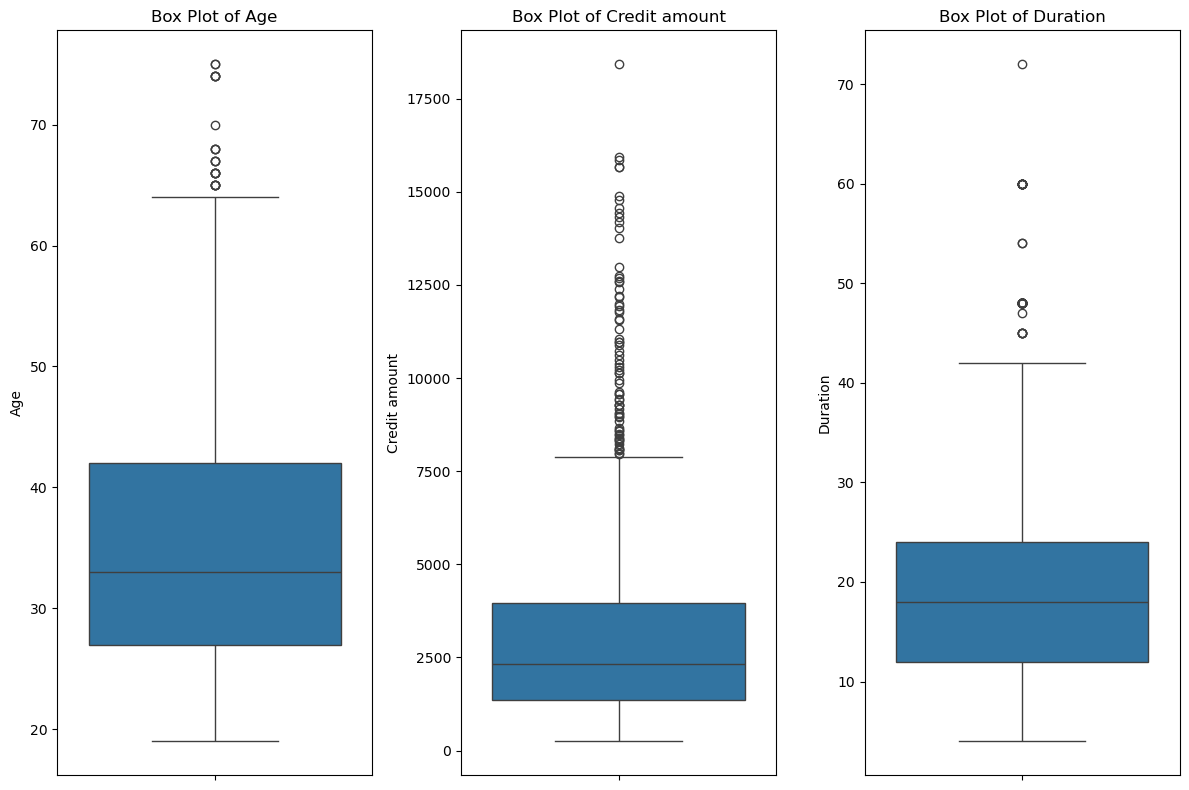

In [47]:
# List of numerical features
num_features = ['Age', 'Credit amount', 'Duration']

# Create a box plot for each feature
plt.figure(figsize=(12, 8))

for i, feature in enumerate(num_features, 1):
    plt.subplot(1, len(num_features), i)
    sns.boxplot(y=df_credit[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

The distribution of sex chart shows that males have a significantly higher count of 'good' credit risk compared to 'bad' credit risk, while females have a lower count for both, with 'good' slightly exceeding 'bad'. This highlights potential gender differences in credit risk outcomes. The "Distribution of Job" chart indicates that job category 1 has the highest count of 'good' credit risk, suggesting individuals in this category are more likely to have good credit risk, whereas job category 0 has a higher proportion of 'bad' credit risk. The "Distribution of Housing" chart shows that owned properties have the highest count for both 'good' and 'bad' conditions, while free and rented properties have lower counts. The "Distribution of Saving accounts" chart reveals that the 'little' category has the highest count of 'good' saving accounts, while the 'quite rich' category has a significant number of 'bad' saving accounts. The "Distribution of Checking account" chart suggests that individuals with little in their accounts are considered higher risk compared to those with moderate or rich balances. Lastly, the "Distribution of Purpose" chart shows that purposes like radio/TV and car have higher counts of 'good' risk, while business and domestic appliances repairs have a more balanced distribution between 'good' and 'bad' risks.

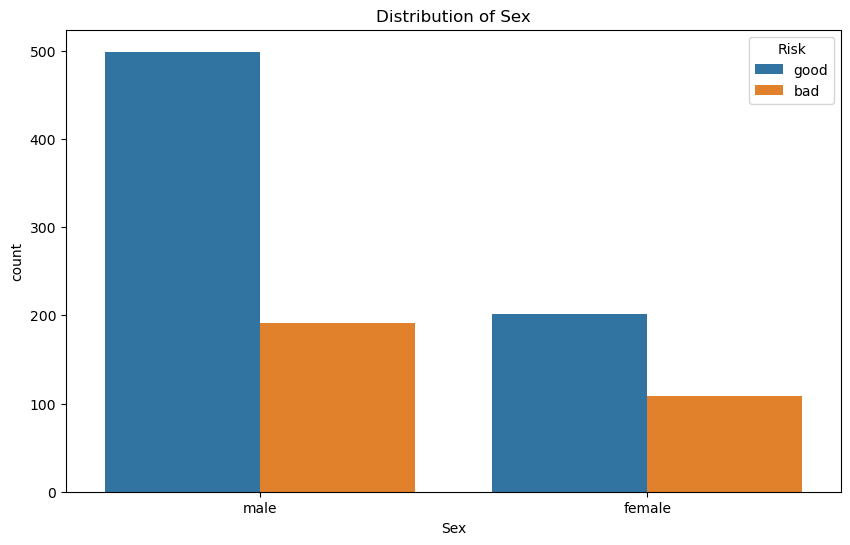

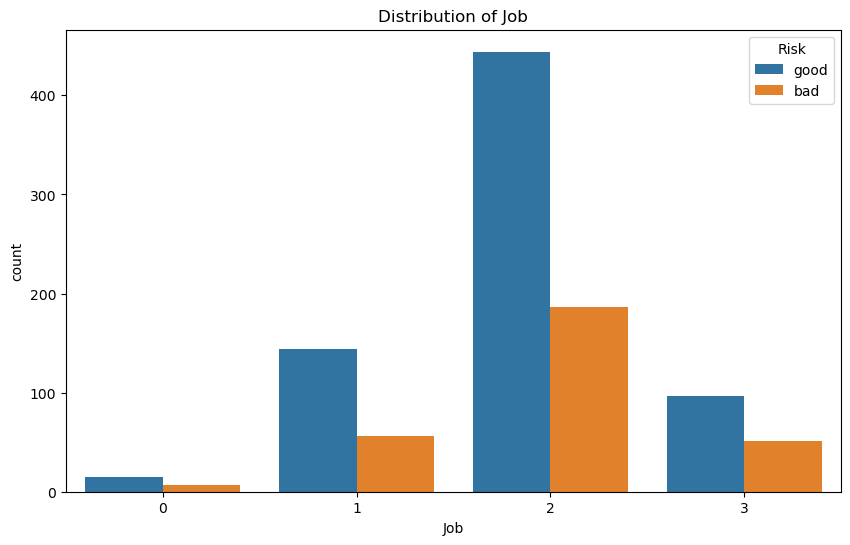

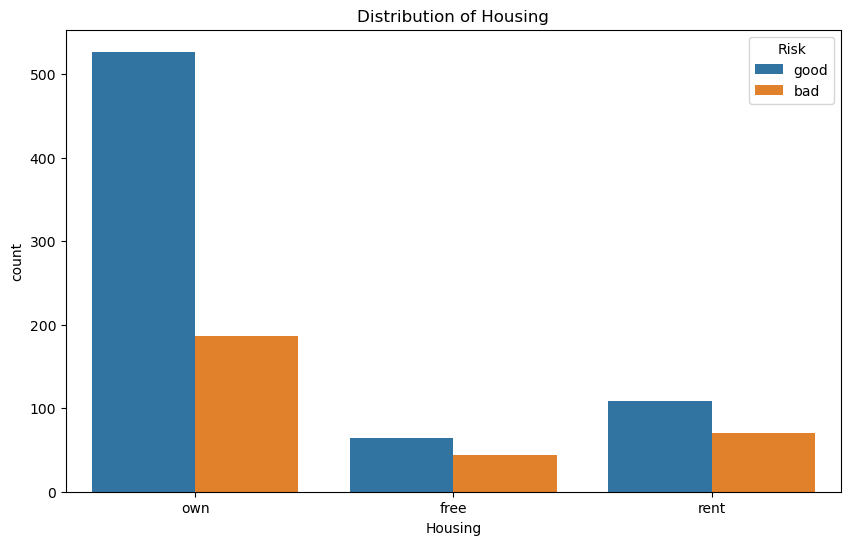

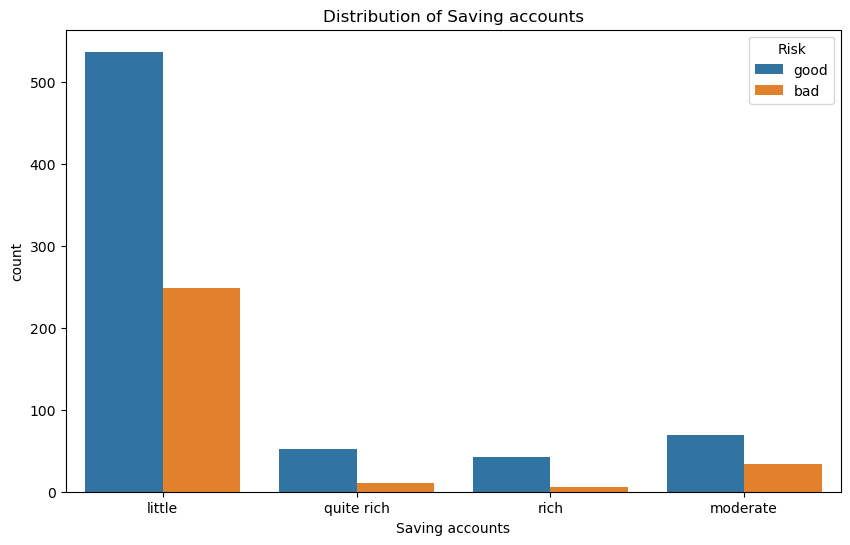

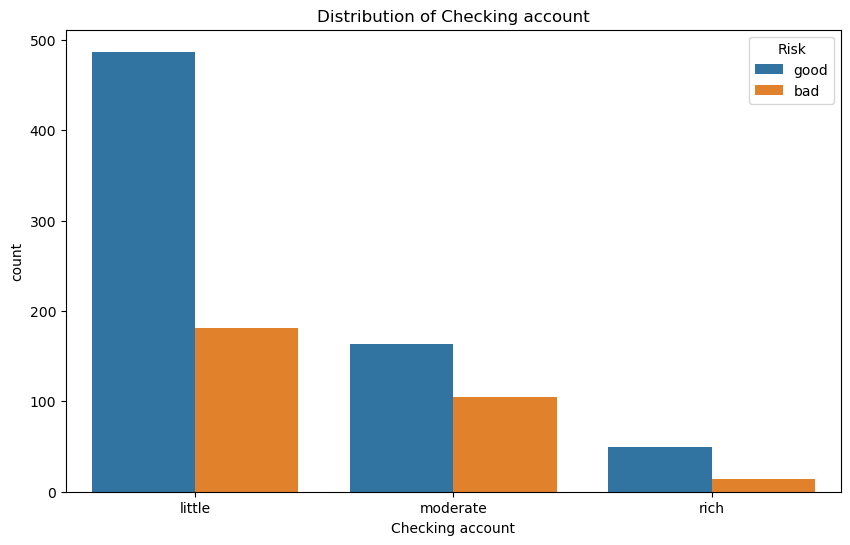

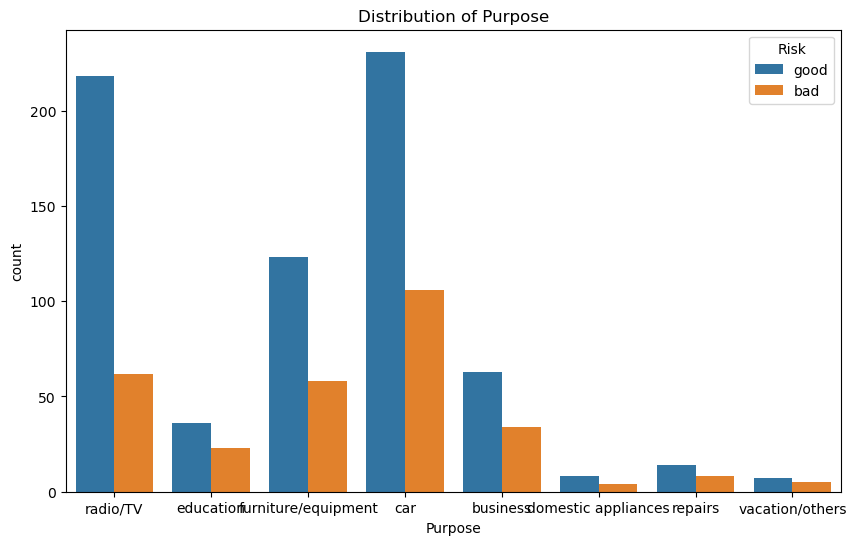

In [9]:
# Visualizing categorical features
cat_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for feature in cat_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Risk', data=df_credit)
    plt.title(f'Distribution of {feature}')
    plt.show()

To prepare the data for analysis, categorical variables are encoded using LabelEncoder. This converts categorical values into numerical values that machine learning algorithms can process. Specifically, the columns ‘Sex’, ‘Housing’, ‘Saving accounts’, ‘Checking account’, and ‘Purpose’ are encoded. Additionally, the ‘Risk’ column is mapped to binary values, with ‘good’ being encoded as 1 and ‘bad’ as 0.

In [10]:
# Data Preprocessing
# Encoding categorical variables
df_credit['Sex'] = LabelEncoder().fit_transform(df_credit['Sex'])
df_credit['Housing'] = LabelEncoder().fit_transform(df_credit['Housing'])
df_credit['Saving accounts'] = LabelEncoder().fit_transform(df_credit['Saving accounts'])
df_credit['Checking account'] = LabelEncoder().fit_transform(df_credit['Checking account'])
df_credit['Purpose'] = LabelEncoder().fit_transform(df_credit['Purpose'])
df_credit['Risk'] = df_credit['Risk'].map({'good': 1, 'bad': 0})

The numerical features ‘Age’, ‘Credit amount’, and ‘Duration’ are identified for standardization. The data is then split into features (X) and the target variable (y), with ‘Risk’ being the target. The StandardScaler is used to standardize the numerical features, ensuring they have a mean of 0 and a standard deviation of 1. This helps in normalizing the data, making it suitable for machine learning algorithms.

In [12]:
num_features = ['Age', 'Credit amount', 'Duration']

# Splitting data into features and target variable
X = df_credit.drop('Risk', axis=1)
y = df_credit['Risk']

# Standardizing numerical features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

The dataset is split into training, validation, and testing sets. Initially, the data is divided into training/validation and testing sets with an 80-20 split, ensuring the target variable y is stratified to maintain the same distribution of classes. Subsequently, the training/validation set is further split into training and validation sets with another 80-20 split, again stratifying by the target variable to preserve class distribution.

In [13]:
# Splitting data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

Class imbalance in the training data is addressed using the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples for the minority class, balancing the dataset. The training data is resampled with SMOTE, resulting in balanced training sets.

In [14]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Several models are defined, including Random Forest, XGBoost, LightGBM, SVM, and Logistic Regression, each with balanced class weights. Hyperparameters for each model are specified in a dictionary, including parameters like `n_estimators`, `max_depth`, `learning_rate`, `C`, and `kernel`. The models are trained, tuned, and evaluated using cross-validation. A `GridSearchCV` is employed to find the best hyperparameters for each model. The best models and their validation scores are recorded. The model with the highest validation score is identified as the best model. Finally, the best model is evaluated on the separate test set to assess its performance.

In [50]:

def evaluate_model(model, X_test, y_test):
    # Predict the test set results
    y_pred = model.predict(X_test)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate and print F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate and print ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Model definitions
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=1/(y_train.mean())),
    'LightGBM': LGBMClassifier(class_weight='balanced'),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(class_weight='balanced')
}

# Hyperparameter tuning
params = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    }
}

# Track validation scores
validation_scores = {}
best_models = {}

# Train, tune, and evaluate models with cross-validation
for model_name in models:
    print(f"\nTraining {model_name}...")
    grid = GridSearchCV(models[model_name], params[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_sm, y_train_sm)
    
    # Store the best model
    best_models[model_name] = grid.best_estimator_
    
    # Record the best validation score
    best_score = grid.best_score_
    validation_scores[model_name] = best_score
    
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best validation score for {model_name}: {best_score:.4f}")

# Determine the best model based on validation score
best_model_name = max(validation_scores, key=validation_scores.get)
print(f"\nBest model based on validation score: {best_model_name}")

# Final evaluation on the separate test set
print("\nFinal evaluation on the separate test set:")
best_model = best_models[best_model_name]
evaluate_model(best_model, X_test, y_test)


Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best validation score for Random Forest: 0.7500

Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Best validation score for XGBoost: 0.7367

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 448, number of negative: 448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [51]:
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.38      0.39        60
           1       0.74      0.76      0.75       140

    accuracy                           0.65       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.64      0.65      0.64       200

Confusion Matrix:
[[ 23  37]
 [ 34 106]]


In [52]:
# Summarize results
results = {}
for model_name in best_models:
    model = best_models[model_name]
    y_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    results[model_name] = auc

best_model_name = max(results, key=results.get)
print(f"The best model is {best_model_name} with a ROC AUC score of {results[best_model_name]:.2f}")

The best model is SVM with a ROC AUC score of 0.65
